In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_percentage_error, roc_curve
from sklearn.metrics import confusion_matrix, f1_score
from lightgbm import LGBMRegressor, LGBMClassifier
from catboost import CatBoostClassifier, CatBoostRegressor
import pickle

import optuna
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_param_importances

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../feature_selection/data/embdedding_features.csv', index_col=0)
df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,percent_nClick,BinNclick
0,3.396450,0.401957,2.514440,-1.278493,0.696468,0.669427,1.454799,-1.411128,-2.325530,-0.340336,...,2.123550,-2.131998,3.520958,5.353183,0.080014,-1.365481,0.852700,-0.551261,0.0,0.0
1,2.752378,2.324396,2.828439,-3.433444,0.401047,-2.011863,-0.728933,-2.993193,-3.696246,1.775527,...,2.362711,-4.364689,4.750610,5.487312,0.432480,-3.199559,-0.086040,-0.206128,0.0,0.0
2,3.490490,1.512165,3.403857,-3.632755,0.310504,-1.970605,-0.608910,-4.947670,-4.198528,2.167250,...,3.768230,-4.947408,6.480114,6.462525,0.973213,-2.188324,-0.684284,0.239616,0.0,0.0
3,2.533500,-0.790464,3.620891,-2.186726,0.025617,0.246850,0.983440,-3.700051,-3.112433,1.624841,...,1.038836,-3.782856,4.963671,6.902436,-0.580284,-1.205756,0.094856,-0.153280,0.0,0.0
4,1.848037,1.126874,3.977530,-4.518314,-0.000538,-2.603749,-1.701738,-5.130782,-4.403915,3.763445,...,1.359940,-6.128437,5.913571,7.023829,-0.172708,-3.132971,-0.755029,0.065173,0.0,0.0


Text(0.5, 1.0, 'Распределение таргетов')

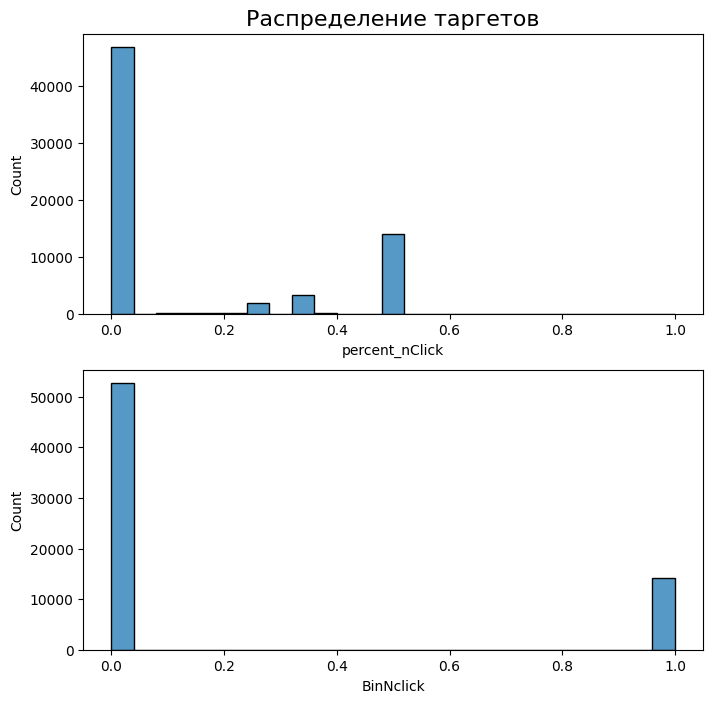

In [3]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))
sns.histplot(
    data=df,
    x='percent_nClick',
    bins=25,
    #kde=True,
    ax=axes[0]
);
sns.histplot(
    data=df,
    x='BinNclick',
    bins=25,
    ax=axes[1]
);
axes[0].set_title('Распределение таргетов', fontsize=16)

### Регрессия

In [4]:
# X = df.drop(['percent_nClick', 'BinNclick'], axis=1)
# y = df['percent_nClick']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# def objective(trial):
#     params={'verbosity':-1,
#             'lambda_l2':trial.suggest_float('lambda_l2', 0.1, 1),
#             'max_depth':trial.suggest_int('max_depth', 5, 100, step=0.05),
#             'num_leaves':trial.suggest_int('num_leaves', 5, 105, step=10),
#             'learning_rate':trial.suggest_float('learning_rate',0.001, 0.1, step=0.01),
#             'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 0.8 , step=0.1)
#             }

#     reg = LGBMRegressor(**params)
#     reg.fit(X_train, y_train)
#     y_pr = reg.predict(X_test)
#     mape = mean_absolute_percentage_error(y_test, y_pr)
#     return mape


# study = optuna.create_study()
# study.optimize(objective, n_trials=100, timeout=60)

## Классификация

In [6]:
# Выделяем таргет
X = df.drop(['percent_nClick', 'BinNclick'], axis=1)
y = df['BinNclick']

# Разделяем данные на тестовые и обучающие
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Посмотрим распределение меток по данным
print(f'Распределение в обучающих данных: {y_train.value_counts()}')
print(f'Распределение в тестовых данных: {y_test.value_counts()}')

Распределение в обучающих данных: BinNclick
0.0    42056
1.0    11431
Name: count, dtype: int64
Распределение в тестовых данных: BinNclick
0.0    10648
1.0     2724
Name: count, dtype: int64


In [7]:
sc=StandardScaler()
sc.fit(X_train)
X_train=sc.transform(X_train)
X_test=sc.transform(X_test)

### LightGBM

In [8]:
def objective_lgbm_class(trial):
    """Определение целевой функции для LightGBM Classification"""
    
    # Задаем сетку параметров
    params = {
        "objective": "binary",
        "boosting_type": "gbdt",
        "depth": trial.suggest_int("depth", 4, 10),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "force_col_wise": True,
        'verbose': -1,
    }

    # Обучение модели
    optuna_model = LGBMClassifier(**params)
    optuna_model.fit(X_train, y_train)

    # Предсказание
    y_pred = optuna_model.predict(X_test)

    # Оценка предсказания
    f1 = f1_score(y_test, y_pred)
    return f1

# Создаем сессию для максимизации выбранной метрики
study_lgbm_class = optuna.create_study(direction='maximize')
# Запускаем нашу сессию оптимизации
study_lgbm_class.optimize(objective_lgbm_class, n_trials=100, timeout=1800)

[I 2024-05-19 18:07:25,945] A new study created in memory with name: no-name-be9d29c1-5947-4a33-b1fd-00ce34e01616
[I 2024-05-19 18:07:27,957] Trial 0 finished with value: 0.16862869869551383 and parameters: {'lambda_l1': 0.000530375676509298, 'lambda_l2': 0.000510019031466659, 'num_leaves': 117, 'feature_fraction': 0.4036481039699737, 'bagging_fraction': 0.8829084207350466, 'bagging_freq': 1, 'min_child_samples': 11}. Best is trial 0 with value: 0.16862869869551383.
[I 2024-05-19 18:07:31,743] Trial 1 finished with value: 0.22379687038677296 and parameters: {'lambda_l1': 0.004511896478486194, 'lambda_l2': 2.855762470872016e-08, 'num_leaves': 185, 'feature_fraction': 0.7958774011738441, 'bagging_fraction': 0.6411983846492082, 'bagging_freq': 2, 'min_child_samples': 76}. Best is trial 1 with value: 0.22379687038677296.
[I 2024-05-19 18:07:33,051] Trial 2 finished with value: 0.11654387139986602 and parameters: {'lambda_l1': 0.002055567238882982, 'lambda_l2': 1.3078905057347223e-08, 'num_

C:\Users\smart\AppData\Local\Temp\ipykernel_11012\682897915.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study_lgbm_class)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

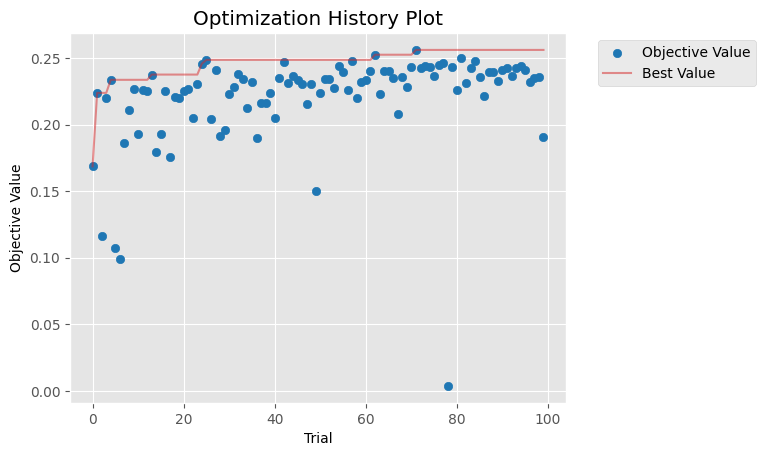

In [9]:
# Посмотрим на процесс подбора параметров на графике
plot_optimization_history(study_lgbm_class)

In [10]:
# Посмотрим на итоги подбора параметров
print('Количество завершенных трайлов: {}'.format(len(study_lgbm_class.trials)))
print('Лучший трайл:')
trial = study_lgbm_class.best_trial

print('  Лучший F1-score: {}'.format(trial.value))
print('  Параметры: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Количество завершенных трайлов: 100
Лучший трайл:
  Лучший F1-score: 0.2560706401766004
  Параметры: 
    lambda_l1: 0.00039701361745962655
    lambda_l2: 6.265748916687016e-05
    num_leaves: 253
    feature_fraction: 0.9522825352936172
    bagging_fraction: 0.464219195280468
    bagging_freq: 4
    min_child_samples: 45


In [14]:
# Обучим модель на получившихся параметрах
params = trial.params
lgbm_class = LGBMClassifier(verbose=-1,**params)
lgbm_class.fit(X_train, y_train)

# Предсказание
y_pred_lgbm = lgbm_class.predict(X_test)
f1_lgbm_class = f1_score(y_test, y_pred_lgbm)

# Выводим основные метрики
print(f"F1-score LightGBM: {round(f1_lgbm_class, 3)}")
print('Classification report LightGBM:')
print(classification_report(y_test, y_pred_lgbm))

F1-score LightGBM: 0.256
Classification report LightGBM:
              precision    recall  f1-score   support

         0.0       0.82      0.96      0.88     10648
         1.0       0.52      0.17      0.26      2724

    accuracy                           0.80     13372
   macro avg       0.67      0.56      0.57     13372
weighted avg       0.76      0.80      0.76     13372



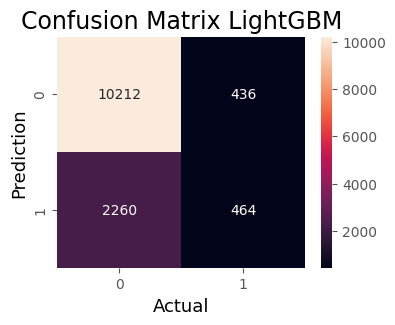

In [15]:
# Посмотрим на матрицу ошибок
plt.figure(figsize=(4, 3))
con_mat_lgbm = confusion_matrix(y_test, y_pred_lgbm)
sns.heatmap(con_mat_lgbm,
            annot=True,
            fmt='g'
            )
plt.ylabel('Prediction', fontsize=13)
plt.xlabel('Actual', fontsize=13)
plt.title('Confusion Matrix LightGBM', fontsize=17)
plt.show()

In [16]:
# Сохраним модель
with open(r'models/lgbm_class_model.pkl', 'wb') as file:
    pickle.dump(lgbm_class, file)

### CatBoost

In [17]:
def objective_catb_class(trial):
    """Определение целевой функции для CatBoost Classification"""

    # Подбираемые параметры
    params = {
        'iterations': trial.suggest_int("iterations", 100, 1000),
        'learning_rate': trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        'depth': trial.suggest_int("depth", 4, 10),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        'random_strength': trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        'bagging_temperature': trial.suggest_float("bagging_temperature", 0.0, 10.0),
        'od_type': trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        'od_wait': trial.suggest_int("od_wait", 10, 50),
        'verbose': 0,
    }

    # Обучение модели
    optuna_model = CatBoostClassifier(**params)
    optuna_model.fit(X_train, y_train)

    # Предсказание
    y_pred = optuna_model.predict(X_test)

    # Оценка полученного предсказания
    f1 = f1_score(y_test, y_pred)
    return f1

# Создаем сессию для максимизации выбранной метрики
study_catb_class = optuna.create_study(direction='maximize')
# Запускаем нашу сессию оптимизации
study_catb_class.optimize(objective_catb_class, n_trials=100, timeout=1800)

[I 2024-05-19 18:17:09,807] A new study created in memory with name: no-name-72ff9b2b-d5fb-441b-8de7-7d4008323722
[I 2024-05-19 18:17:18,467] Trial 0 finished with value: 0.09370725034199727 and parameters: {'iterations': 272, 'learning_rate': 0.04990519427513023, 'depth': 6, 'l2_leaf_reg': 1.5057436321035076e-08, 'random_strength': 6.625184950437742e-07, 'bagging_temperature': 9.632309342968407, 'od_type': 'IncToDec', 'od_wait': 18}. Best is trial 0 with value: 0.09370725034199727.
[I 2024-05-19 18:17:42,865] Trial 1 finished with value: 0.11748909029875797 and parameters: {'iterations': 214, 'learning_rate': 0.030138018718535844, 'depth': 9, 'l2_leaf_reg': 9.986670779139622e-05, 'random_strength': 4.452716440173417e-08, 'bagging_temperature': 6.537084593306725, 'od_type': 'IncToDec', 'od_wait': 36}. Best is trial 1 with value: 0.11748909029875797.
[I 2024-05-19 18:17:46,525] Trial 2 finished with value: 0.013086150490730641 and parameters: {'iterations': 103, 'learning_rate': 0.01329

C:\Users\smart\AppData\Local\Temp\ipykernel_11012\4076140752.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study_catb_class)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

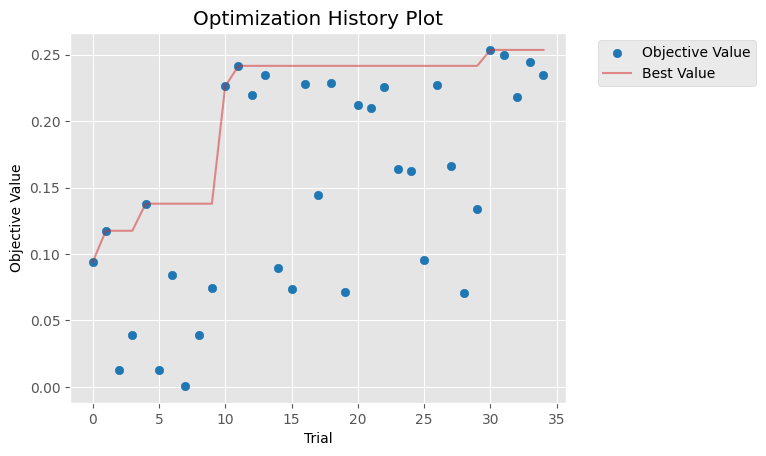

In [18]:
# Посмотрим как проходл процесс подбора параметров на графике
plot_optimization_history(study_catb_class)

In [19]:
# Посмотрим на итоги подбора параметров
print('Количество завершенных трайлов: {}'.format(len(study_catb_class.trials)))
print('Лучший трайл:')
trial = study_catb_class.best_trial

print('  Лучший F1-score: {}'.format(trial.value))
print('  Параметры: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Количество завершенных трайлов: 35
Лучший трайл:
  Лучший F1-score: 0.2535589578297072
  Параметры: 
    iterations: 920
    learning_rate: 0.07690594124602057
    depth: 8
    l2_leaf_reg: 2.528492794875421e-05
    random_strength: 1.9701194238641476e-07
    bagging_temperature: 0.7785745490027935
    od_type: IncToDec
    od_wait: 24


In [20]:
# Обучим модель с полученными параметрами
params = trial.params
catb_class = CatBoostClassifier(verbose=0,**params)
catb_class.fit(X_train, y_train)

# Предсказание
y_pred_catb = catb_class.predict(X_test)
f1_catb_class = f1_score(y_test, y_pred_catb)

# Посмотрим на основные метрики качества
print(f"F1-score CatBoost: {round(f1_catb_class, 3)}")
print('Classification report CatBoost:')
print(classification_report(y_test, y_pred_catb))

0:	learn: 0.6610986	total: 85.2ms	remaining: 1m 18s
1:	learn: 0.6341200	total: 181ms	remaining: 1m 22s
2:	learn: 0.6117128	total: 256ms	remaining: 1m 18s
3:	learn: 0.5925617	total: 328ms	remaining: 1m 15s
4:	learn: 0.5764878	total: 395ms	remaining: 1m 12s
5:	learn: 0.5624311	total: 460ms	remaining: 1m 10s
6:	learn: 0.5509578	total: 524ms	remaining: 1m 8s
7:	learn: 0.5409868	total: 590ms	remaining: 1m 7s
8:	learn: 0.5327806	total: 658ms	remaining: 1m 6s
9:	learn: 0.5255417	total: 725ms	remaining: 1m 5s
10:	learn: 0.5193117	total: 793ms	remaining: 1m 5s
11:	learn: 0.5142270	total: 860ms	remaining: 1m 5s
12:	learn: 0.5094495	total: 927ms	remaining: 1m 4s
13:	learn: 0.5054437	total: 990ms	remaining: 1m 4s
14:	learn: 0.5019551	total: 1.05s	remaining: 1m 3s
15:	learn: 0.4989021	total: 1.12s	remaining: 1m 3s
16:	learn: 0.4964313	total: 1.19s	remaining: 1m 3s
17:	learn: 0.4940959	total: 1.26s	remaining: 1m 3s
18:	learn: 0.4921953	total: 1.32s	remaining: 1m 2s
19:	learn: 0.4900468	total: 1.39s	

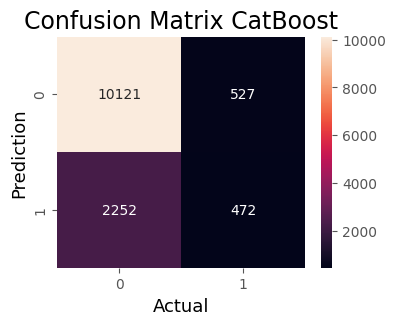

In [21]:
# Потроим матрицу ошибок
plt.figure(figsize=(4, 3))
con_mat_catb = confusion_matrix(y_test, y_pred_catb)
sns.heatmap(con_mat_catb,
            annot=True,
            fmt='g'
            )
plt.ylabel('Prediction', fontsize=13)
plt.xlabel('Actual', fontsize=13)
plt.title('Confusion Matrix CatBoost', fontsize=17)
plt.show()

In [22]:
# Сохраним полученную модель
with open(r'models/catb_class_model.pkl', 'wb') as file:
    pickle.dump(catb_class, file)

### XGBoost

In [23]:
def objective_xgb_class(trial):
    """Определение целевой функции для XGBoost Classification"""

    # Подбираемые параметры
    params = {
        'verbosity': 0,
        'objective': 'binary:logistic',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }

    # Обучение модели
    optuna_model = XGBClassifier(**params)
    optuna_model.fit(X_train, y_train)

    # Предсказание
    y_pred = optuna_model.predict(X_test)

    # Оценка полученного предсказания
    f1 = f1_score(y_test, y_pred)
    return f1

# Создаем сессию для максимизации выбранной метрики
study_xgb_class = optuna.create_study(direction='maximize')
# Запускаем нашу сессию оптимизации
study_xgb_class.optimize(objective_xgb_class, n_trials=100, timeout=1800)

[I 2024-05-19 19:24:34,463] A new study created in memory with name: no-name-be33b0d5-b434-4bb7-bdec-0e38c9b9aeb3


[19:24:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_child_samples" } are not used.



[I 2024-05-19 19:24:39,769] Trial 0 finished with value: 0.1794871794871795 and parameters: {'max_depth': 4, 'learning_rate': 0.5537048768259604, 'n_estimators': 52, 'min_child_weight': 1, 'min_child_samples': 44, 'gamma': 0.951065498065423, 'subsample': 0.5849950471713473, 'colsample_bytree': 0.5582790530136882}. Best is trial 0 with value: 0.1794871794871795.


[19:24:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_child_samples" } are not used.



[I 2024-05-19 19:25:26,795] Trial 1 finished with value: 0.22668900055834726 and parameters: {'max_depth': 4, 'learning_rate': 0.30032135423840084, 'n_estimators': 397, 'min_child_weight': 8, 'min_child_samples': 9, 'gamma': 0.9976389178271647, 'subsample': 0.5192154337219264, 'colsample_bytree': 0.7710155387084143}. Best is trial 1 with value: 0.22668900055834726.


[19:25:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_child_samples" } are not used.



[I 2024-05-19 19:27:10,827] Trial 2 finished with value: 0.11505922165820642 and parameters: {'max_depth': 9, 'learning_rate': 0.012779477902036375, 'n_estimators': 389, 'min_child_weight': 10, 'min_child_samples': 49, 'gamma': 0.5825610530159849, 'subsample': 0.4800467069967232, 'colsample_bytree': 0.7102490597619536}. Best is trial 1 with value: 0.22668900055834726.


[19:27:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_child_samples" } are not used.



[I 2024-05-19 19:27:17,404] Trial 3 finished with value: 0.15397973950795948 and parameters: {'max_depth': 1, 'learning_rate': 0.8221790742818177, 'n_estimators': 427, 'min_child_weight': 2, 'min_child_samples': 16, 'gamma': 0.3277254611599482, 'subsample': 0.14564516725214965, 'colsample_bytree': 0.33185057477200963}. Best is trial 1 with value: 0.22668900055834726.


[19:27:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_child_samples" } are not used.



[I 2024-05-19 19:27:38,904] Trial 4 finished with value: 0.2857803468208092 and parameters: {'max_depth': 9, 'learning_rate': 0.6410758710561174, 'n_estimators': 144, 'min_child_weight': 1, 'min_child_samples': 44, 'gamma': 0.4421199127835708, 'subsample': 0.896313503339473, 'colsample_bytree': 0.25740290769585705}. Best is trial 4 with value: 0.2857803468208092.


[19:27:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_child_samples" } are not used.



[I 2024-05-19 19:28:32,227] Trial 5 finished with value: 0.30569727891156456 and parameters: {'max_depth': 8, 'learning_rate': 0.7330863720635035, 'n_estimators': 290, 'min_child_weight': 4, 'min_child_samples': 74, 'gamma': 0.0032782098854335414, 'subsample': 0.7483242102968215, 'colsample_bytree': 0.46643467971131725}. Best is trial 5 with value: 0.30569727891156456.


[19:28:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_child_samples" } are not used.



[I 2024-05-19 19:28:54,338] Trial 6 finished with value: 0.07246376811594203 and parameters: {'max_depth': 1, 'learning_rate': 0.5567346744200199, 'n_estimators': 467, 'min_child_weight': 4, 'min_child_samples': 74, 'gamma': 0.5173021420481951, 'subsample': 0.842934818204701, 'colsample_bytree': 0.8610075068660216}. Best is trial 5 with value: 0.30569727891156456.


[19:28:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_child_samples" } are not used.



[I 2024-05-19 19:29:01,922] Trial 7 finished with value: 0.21544420237230694 and parameters: {'max_depth': 5, 'learning_rate': 0.27549199844982525, 'n_estimators': 263, 'min_child_weight': 2, 'min_child_samples': 34, 'gamma': 0.8196768731309881, 'subsample': 0.11021698674934363, 'colsample_bytree': 0.055424671524389464}. Best is trial 5 with value: 0.30569727891156456.


[19:29:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_child_samples" } are not used.



[I 2024-05-19 19:29:54,178] Trial 8 finished with value: 0.2955894826123834 and parameters: {'max_depth': 7, 'learning_rate': 0.321642717991883, 'n_estimators': 326, 'min_child_weight': 3, 'min_child_samples': 78, 'gamma': 0.31566960355522966, 'subsample': 0.26236363915172767, 'colsample_bytree': 0.9977018559338909}. Best is trial 5 with value: 0.30569727891156456.


[19:29:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_child_samples" } are not used.



[I 2024-05-19 19:31:52,231] Trial 9 finished with value: 0.28778937812074445 and parameters: {'max_depth': 8, 'learning_rate': 0.7292732518923963, 'n_estimators': 363, 'min_child_weight': 7, 'min_child_samples': 72, 'gamma': 0.9029269866617843, 'subsample': 0.9952252604360493, 'colsample_bytree': 0.7566873972028786}. Best is trial 5 with value: 0.30569727891156456.


[19:31:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_child_samples" } are not used.



[I 2024-05-19 19:32:27,575] Trial 10 finished with value: 0.3035219628017412 and parameters: {'max_depth': 7, 'learning_rate': 0.9848406924227243, 'n_estimators': 232, 'min_child_weight': 5, 'min_child_samples': 96, 'gamma': 0.057904260006604924, 'subsample': 0.7240844882080886, 'colsample_bytree': 0.4510294592995028}. Best is trial 5 with value: 0.30569727891156456.


[19:32:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_child_samples" } are not used.



[I 2024-05-19 19:33:01,586] Trial 11 finished with value: 0.2986909956366521 and parameters: {'max_depth': 7, 'learning_rate': 0.9944688101081289, 'n_estimators': 226, 'min_child_weight': 5, 'min_child_samples': 99, 'gamma': 0.0032260812550661475, 'subsample': 0.7163933405410731, 'colsample_bytree': 0.4294002625550283}. Best is trial 5 with value: 0.30569727891156456.


[19:33:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_child_samples" } are not used.



[I 2024-05-19 19:33:31,601] Trial 12 finished with value: 0.3001230012300123 and parameters: {'max_depth': 6, 'learning_rate': 0.9159177355440813, 'n_estimators': 194, 'min_child_weight': 6, 'min_child_samples': 99, 'gamma': 0.013981468633478725, 'subsample': 0.7093628496148039, 'colsample_bytree': 0.5615423978048907}. Best is trial 5 with value: 0.30569727891156456.


[19:33:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_child_samples" } are not used.



[I 2024-05-19 19:33:49,611] Trial 13 finished with value: 0.28693009118541035 and parameters: {'max_depth': 7, 'learning_rate': 0.8085311419657693, 'n_estimators': 293, 'min_child_weight': 5, 'min_child_samples': 86, 'gamma': 0.14876321491712297, 'subsample': 0.6765357311177446, 'colsample_bytree': 0.12283440867977619}. Best is trial 5 with value: 0.30569727891156456.


[19:33:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_child_samples" } are not used.



[I 2024-05-19 19:34:07,666] Trial 14 finished with value: 0.2794899043570669 and parameters: {'max_depth': 8, 'learning_rate': 0.9797112498668463, 'n_estimators': 151, 'min_child_weight': 4, 'min_child_samples': 62, 'gamma': 0.21114703121948403, 'subsample': 0.3821290391872512, 'colsample_bytree': 0.44745077354655216}. Best is trial 5 with value: 0.30569727891156456.


[19:34:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_child_samples" } are not used.



[I 2024-05-19 19:34:26,771] Trial 15 finished with value: 0.2657471264367816 and parameters: {'max_depth': 5, 'learning_rate': 0.8348420962959214, 'n_estimators': 248, 'min_child_weight': 8, 'min_child_samples': 88, 'gamma': 0.11011520844406722, 'subsample': 0.8485273070783431, 'colsample_bytree': 0.2653974148209537}. Best is trial 5 with value: 0.30569727891156456.


[19:34:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_child_samples" } are not used.



[I 2024-05-19 19:35:18,518] Trial 16 finished with value: 0.29001650165016507 and parameters: {'max_depth': 6, 'learning_rate': 0.7189539500240134, 'n_estimators': 329, 'min_child_weight': 6, 'min_child_samples': 60, 'gamma': 0.6660648551363204, 'subsample': 0.6267982091331402, 'colsample_bytree': 0.6316584733994731}. Best is trial 5 with value: 0.30569727891156456.


[19:35:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_child_samples" } are not used.



[I 2024-05-19 19:35:25,743] Trial 17 finished with value: 0.11430459200528575 and parameters: {'max_depth': 3, 'learning_rate': 0.45302237022955794, 'n_estimators': 98, 'min_child_weight': 4, 'min_child_samples': 88, 'gamma': 0.29316084064998815, 'subsample': 0.775099453301634, 'colsample_bytree': 0.3936360975719022}. Best is trial 5 with value: 0.30569727891156456.


[19:35:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_child_samples" } are not used.



[I 2024-05-19 19:35:40,983] Trial 18 finished with value: 0.28806290207290924 and parameters: {'max_depth': 8, 'learning_rate': 0.8904595527819256, 'n_estimators': 186, 'min_child_weight': 3, 'min_child_samples': 65, 'gamma': 0.10452127826961763, 'subsample': 0.4302520689794004, 'colsample_bytree': 0.18572233689554685}. Best is trial 5 with value: 0.30569727891156456.


[19:35:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_child_samples" } are not used.



[I 2024-05-19 19:36:53,903] Trial 19 finished with value: 0.28212290502793297 and parameters: {'max_depth': 9, 'learning_rate': 0.6796455767051819, 'n_estimators': 301, 'min_child_weight': 7, 'min_child_samples': 82, 'gamma': 0.3982214427818881, 'subsample': 0.9768439436918153, 'colsample_bytree': 0.49719093345010784}. Best is trial 5 with value: 0.30569727891156456.


[19:36:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_child_samples" } are not used.



[I 2024-05-19 19:37:17,366] Trial 20 finished with value: 0.28693790149892934 and parameters: {'max_depth': 6, 'learning_rate': 0.4357556135234148, 'n_estimators': 228, 'min_child_weight': 3, 'min_child_samples': 95, 'gamma': 0.2167005432635974, 'subsample': 0.3238056658743562, 'colsample_bytree': 0.6222422367058233}. Best is trial 5 with value: 0.30569727891156456.


[19:37:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_child_samples" } are not used.



[I 2024-05-19 19:37:50,175] Trial 21 finished with value: 0.28900782214903253 and parameters: {'max_depth': 6, 'learning_rate': 0.9224731987979197, 'n_estimators': 197, 'min_child_weight': 6, 'min_child_samples': 95, 'gamma': 0.015484032929286129, 'subsample': 0.7178311493367111, 'colsample_bytree': 0.5637591158212744}. Best is trial 5 with value: 0.30569727891156456.


[19:37:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_child_samples" } are not used.



[I 2024-05-19 19:38:14,089] Trial 22 finished with value: 0.2880094043887147 and parameters: {'max_depth': 7, 'learning_rate': 0.8950587757599602, 'n_estimators': 170, 'min_child_weight': 5, 'min_child_samples': 100, 'gamma': 0.05472186670097559, 'subsample': 0.5735952621463393, 'colsample_bytree': 0.3345180249646682}. Best is trial 5 with value: 0.30569727891156456.


[19:38:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_child_samples" } are not used.



[I 2024-05-19 19:38:37,770] Trial 23 finished with value: 0.30179692574150246 and parameters: {'max_depth': 8, 'learning_rate': 0.7806276860329499, 'n_estimators': 117, 'min_child_weight': 7, 'min_child_samples': 69, 'gamma': 0.18281405982551852, 'subsample': 0.7700801055859225, 'colsample_bytree': 0.5363603578359243}. Best is trial 5 with value: 0.30569727891156456.


[19:38:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_child_samples" } are not used.



[I 2024-05-19 19:39:05,333] Trial 24 finished with value: 0.2823152596659803 and parameters: {'max_depth': 8, 'learning_rate': 0.755879443108658, 'n_estimators': 105, 'min_child_weight': 10, 'min_child_samples': 70, 'gamma': 0.1901061485195259, 'subsample': 0.8073858461791438, 'colsample_bytree': 0.48714243474103686}. Best is trial 5 with value: 0.30569727891156456.


[19:39:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_child_samples" } are not used.



[I 2024-05-19 19:39:33,797] Trial 25 finished with value: 0.27226401358893465 and parameters: {'max_depth': 8, 'learning_rate': 0.6084921224420583, 'n_estimators': 117, 'min_child_weight': 8, 'min_child_samples': 31, 'gamma': 0.10038206295793986, 'subsample': 0.9134875668824173, 'colsample_bytree': 0.39379687377235983}. Best is trial 5 with value: 0.30569727891156456.


[19:39:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_child_samples" } are not used.



[I 2024-05-19 19:39:57,750] Trial 26 finished with value: 0.28965819456617004 and parameters: {'max_depth': 9, 'learning_rate': 0.7987135454377738, 'n_estimators': 68, 'min_child_weight': 7, 'min_child_samples': 57, 'gamma': 0.25570312971669396, 'subsample': 0.7754714715123803, 'colsample_bytree': 0.6489554296433855}. Best is trial 5 with value: 0.30569727891156456.


[19:39:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_child_samples" } are not used.



[I 2024-05-19 19:40:42,526] Trial 27 finished with value: 0.2943207981580967 and parameters: {'max_depth': 7, 'learning_rate': 0.9861582092083258, 'n_estimators': 333, 'min_child_weight': 9, 'min_child_samples': 80, 'gamma': 0.16442772865024635, 'subsample': 0.6358533839256791, 'colsample_bytree': 0.31769236430534076}. Best is trial 5 with value: 0.30569727891156456.


[19:40:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_child_samples" } are not used.



[I 2024-05-19 19:41:50,071] Trial 28 finished with value: 0.2969451931716083 and parameters: {'max_depth': 8, 'learning_rate': 0.6589102597552777, 'n_estimators': 279, 'min_child_weight': 4, 'min_child_samples': 72, 'gamma': 0.07708284501651497, 'subsample': 0.8936133577555356, 'colsample_bytree': 0.5231154702250927}. Best is trial 5 with value: 0.30569727891156456.


[19:41:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_child_samples" } are not used.



[I 2024-05-19 19:41:56,750] Trial 29 finished with value: 0.1561065197428834 and parameters: {'max_depth': 4, 'learning_rate': 0.5343868085012873, 'n_estimators': 50, 'min_child_weight': 5, 'min_child_samples': 51, 'gamma': 0.374522106599082, 'subsample': 0.5607935806809047, 'colsample_bytree': 0.5736219366005119}. Best is trial 5 with value: 0.30569727891156456.


[19:41:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_child_samples" } are not used.



[I 2024-05-19 19:42:07,093] Trial 30 finished with value: 0.0 and parameters: {'max_depth': 5, 'learning_rate': 0.010864235560221147, 'n_estimators': 233, 'min_child_weight': 6, 'min_child_samples': 66, 'gamma': 0.2589506281052031, 'subsample': 0.012283053653596443, 'colsample_bytree': 0.7029982010718697}. Best is trial 5 with value: 0.30569727891156456.


[19:42:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_child_samples" } are not used.



[I 2024-05-19 19:42:39,417] Trial 31 finished with value: 0.3069652763509349 and parameters: {'max_depth': 6, 'learning_rate': 0.9010716126382375, 'n_estimators': 203, 'min_child_weight': 6, 'min_child_samples': 93, 'gamma': 0.009804334317548166, 'subsample': 0.7145749749434895, 'colsample_bytree': 0.5501335890248775}. Best is trial 31 with value: 0.3069652763509349.


[19:42:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_child_samples" } are not used.



[I 2024-05-19 19:43:07,376] Trial 32 finished with value: 0.291374824894937 and parameters: {'max_depth': 7, 'learning_rate': 0.8721774074788256, 'n_estimators': 209, 'min_child_weight': 7, 'min_child_samples': 91, 'gamma': 0.06948984305376281, 'subsample': 0.6482100917419714, 'colsample_bytree': 0.4756118311849783}. Best is trial 31 with value: 0.3069652763509349.


[19:43:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_child_samples" } are not used.



[I 2024-05-19 19:43:23,894] Trial 33 finished with value: 0.28959276018099545 and parameters: {'max_depth': 6, 'learning_rate': 0.9507521929002145, 'n_estimators': 137, 'min_child_weight': 6, 'min_child_samples': 82, 'gamma': 0.14370743325639734, 'subsample': 0.5203643973686538, 'colsample_bytree': 0.3930318277516882}. Best is trial 31 with value: 0.3069652763509349.


[19:43:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_child_samples" } are not used.



[I 2024-05-19 19:44:16,086] Trial 34 finished with value: 0.3011794439764111 and parameters: {'max_depth': 9, 'learning_rate': 0.7784668754650309, 'n_estimators': 169, 'min_child_weight': 9, 'min_child_samples': 76, 'gamma': 0.0034883386931757144, 'subsample': 0.7589715753943952, 'colsample_bytree': 0.6881926387456506}. Best is trial 31 with value: 0.3069652763509349.


[19:44:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_child_samples" } are not used.



[I 2024-05-19 19:44:31,364] Trial 35 finished with value: 0.16332726168791742 and parameters: {'max_depth': 2, 'learning_rate': 0.8309262324551823, 'n_estimators': 255, 'min_child_weight': 5, 'min_child_samples': 91, 'gamma': 0.056398567438182445, 'subsample': 0.8342766050750733, 'colsample_bytree': 0.5298365857130842}. Best is trial 31 with value: 0.3069652763509349.


[19:44:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_child_samples" } are not used.



[I 2024-05-19 19:45:12,440] Trial 36 finished with value: 0.14610701698173661 and parameters: {'max_depth': 5, 'learning_rate': 0.10497003601901833, 'n_estimators': 372, 'min_child_weight': 7, 'min_child_samples': 56, 'gamma': 0.7129869601030266, 'subsample': 0.49506377348716696, 'colsample_bytree': 0.6078652522219523}. Best is trial 31 with value: 0.3069652763509349.


[19:45:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_child_samples" } are not used.



[I 2024-05-19 19:45:33,762] Trial 37 finished with value: 0.2665688432379555 and parameters: {'max_depth': 7, 'learning_rate': 0.7029683534732257, 'n_estimators': 78, 'min_child_weight': 4, 'min_child_samples': 45, 'gamma': 0.13948786827262277, 'subsample': 0.9220095682393037, 'colsample_bytree': 0.7982245953998197}. Best is trial 31 with value: 0.3069652763509349.


[19:45:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_child_samples" } are not used.



[I 2024-05-19 19:46:20,253] Trial 38 finished with value: 0.2958477508650519 and parameters: {'max_depth': 9, 'learning_rate': 0.6092047990083307, 'n_estimators': 300, 'min_child_weight': 1, 'min_child_samples': 84, 'gamma': 0.4850494263307647, 'subsample': 0.5970518113513695, 'colsample_bytree': 0.31276857233273014}. Best is trial 31 with value: 0.3069652763509349.


[19:46:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_child_samples" } are not used.



[I 2024-05-19 19:48:40,910] Trial 39 finished with value: 0.3057715923045436 and parameters: {'max_depth': 8, 'learning_rate': 0.8581099698202991, 'n_estimators': 410, 'min_child_weight': 2, 'min_child_samples': 35, 'gamma': 0.5759338560978794, 'subsample': 0.7043563662764244, 'colsample_bytree': 0.8704411418462255}. Best is trial 31 with value: 0.3069652763509349.


[19:48:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_child_samples" } are not used.



[I 2024-05-19 19:50:46,269] Trial 40 finished with value: 0.2995504699632202 and parameters: {'max_depth': 6, 'learning_rate': 0.8669534477885393, 'n_estimators': 458, 'min_child_weight': 3, 'min_child_samples': 35, 'gamma': 0.5682570891954898, 'subsample': 0.6802293893219981, 'colsample_bytree': 0.9037382024647087}. Best is trial 31 with value: 0.3069652763509349.


[19:50:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_child_samples" } are not used.



[I 2024-05-19 19:53:10,223] Trial 41 finished with value: 0.2987174182871328 and parameters: {'max_depth': 8, 'learning_rate': 0.9309042706276258, 'n_estimators': 419, 'min_child_weight': 2, 'min_child_samples': 24, 'gamma': 0.7666798666112143, 'subsample': 0.7413457116184924, 'colsample_bytree': 0.9392684255719983}. Best is trial 31 with value: 0.3069652763509349.


[19:53:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_child_samples" } are not used.



[I 2024-05-19 19:55:34,268] Trial 42 finished with value: 0.30410122164048864 and parameters: {'max_depth': 8, 'learning_rate': 0.754375041381831, 'n_estimators': 432, 'min_child_weight': 2, 'min_child_samples': 10, 'gamma': 0.600047717935372, 'subsample': 0.8119514743281765, 'colsample_bytree': 0.7650813512119413}. Best is trial 31 with value: 0.3069652763509349.


C:\Users\smart\AppData\Local\Temp\ipykernel_11012\400001077.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study_xgb_class)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

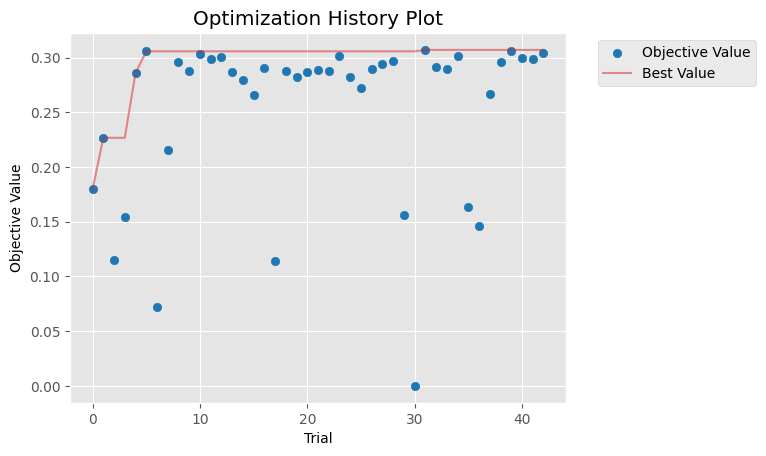

In [24]:
# Посмотрим как проходл процесс подбора параметров на графике
plot_optimization_history(study_xgb_class)

In [25]:
#plot_param_importances(study_xgb_class)

In [26]:
# Посмотрим на итоги подбора параметров
print('Количество завершенных трайлов: {}'.format(len(study_xgb_class.trials)))
print('Лучший трайл:')
trial = study_xgb_class.best_trial

print('  Лучший F1-score: {}'.format(trial.value))
print('  Параметры: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Количество завершенных трайлов: 43
Лучший трайл:
  Лучший F1-score: 0.3069652763509349
  Параметры: 
    max_depth: 6
    learning_rate: 0.9010716126382375
    n_estimators: 203
    min_child_weight: 6
    min_child_samples: 93
    gamma: 0.009804334317548166
    subsample: 0.7145749749434895
    colsample_bytree: 0.5501335890248775


In [27]:
# Обучим модель с полученными параметрами
params = trial.params
xgb_class = XGBClassifier(**params)
xgb_class.fit(X_train, y_train)

# Предсказание
y_pred_xgb = xgb_class.predict(X_test)
f1_xgb_class = f1_score(y_test, y_pred_xgb)

# Посмотрим на основные метрики качества
print(f"F1-score XGBoost: {round(f1_xgb_class, 3)}")
print('Classification report XGBoost:')
print(classification_report(y_test, y_pred_xgb))

[19:55:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_child_samples" } are not used.

F1-score XGBoost: 0.307
Classification report XGBoost:
              precision    recall  f1-score   support

         0.0       0.82      0.87      0.85     10648
         1.0       0.35      0.27      0.31      2724

    accuracy                           0.75     13372
   macro avg       0.59      0.57      0.58     13372
weighted avg       0.73      0.75      0.74     13372



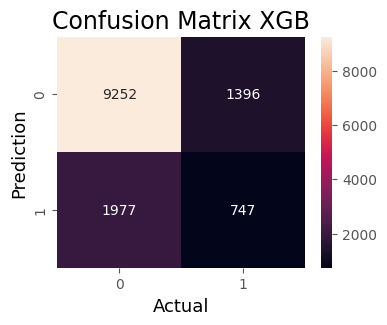

In [28]:
# Потроим матрицу ошибок
plt.figure(figsize=(4, 3))
con_mat_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(con_mat_xgb,
            annot=True,
            fmt='g'
            )
plt.ylabel('Prediction', fontsize=13)
plt.xlabel('Actual', fontsize=13)
plt.title('Confusion Matrix XGB', fontsize=17)
plt.show()

In [29]:
# Сохраним полученную модель
with open(r'models/xgb_class_model.pkl', 'wb') as file:
    pickle.dump(xgb_class, file)

In [30]:
# sns.set_color_codes("muted")

# plt.figure(figsize=(6, 6))
# fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
# lw = 2
# plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
# plt.plot([0, 1], [0, 1])
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC curve')
# #plt.savefig("ROC.png")
# plt.show()